$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [17]:
# Activate intractive functionality of matplotlib
%matplotlib notebook
# import libraries
import os
import os.path as path
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools

In [18]:
# if recieve error for pytables library you should uncomment the line below and run the cell
import sys
# !conda install --yes --prefix {sys.prefix} pytables

$\text{Path to the dataset}$

In [19]:
tdc_model = 'roentdec' # TDC model: surface_concept or roentdec

# dataset name
# dataset_name = 'AL_data_b'
# dataset_name = 'OLO_AL_6_data'
# dataset_name = 'OLO_W_6_data'
# dataset_name = 'OLO_Ni_8_data'
# dataset_name = 'X6Cr17_2V30Min_5_data'
# dataset_name = "data_1029_Jun-27-2022_15-53_Pd"
# dataset_name = "data_1040_Jul-14-2022_15-47_Vicente_W"
dataset_name = "data_115_Jul-27-2022_17-44_Powersweep3"

p = path.abspath(path.join("", "../../../../.."))

variables.init()
variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.join(p, 'tests/results/load_crop/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
# dataset name
filename = variables.path + '//' + dataset_name + '.h5'
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dldGroupStorage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc_model)
dld_masterDataframe = data_loadcrop.concatenate_dataframes_of_dld_grp(dldGroupStorage)
print('Total number of Ions:', len(dldGroupStorage[0]))

{'apt': ['high_voltage', 'num_events', 'time_counter'], 'cropped_dld': ['high_voltage', 'laser_intensity', 'start_counter', 't', 'x', 'y'], 'dld': ['AbsoluteTimeStamp', 'high_voltage', 'laser_intensity', 't', 'x', 'y'], 'tdc': ['ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7'], 'time': ['time_h', 'time_m', 'time_s']}
(915152,)
(636668,)
(636458,)
Total number of Ions: 636458


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

<IPython.core.display.Javascript object>


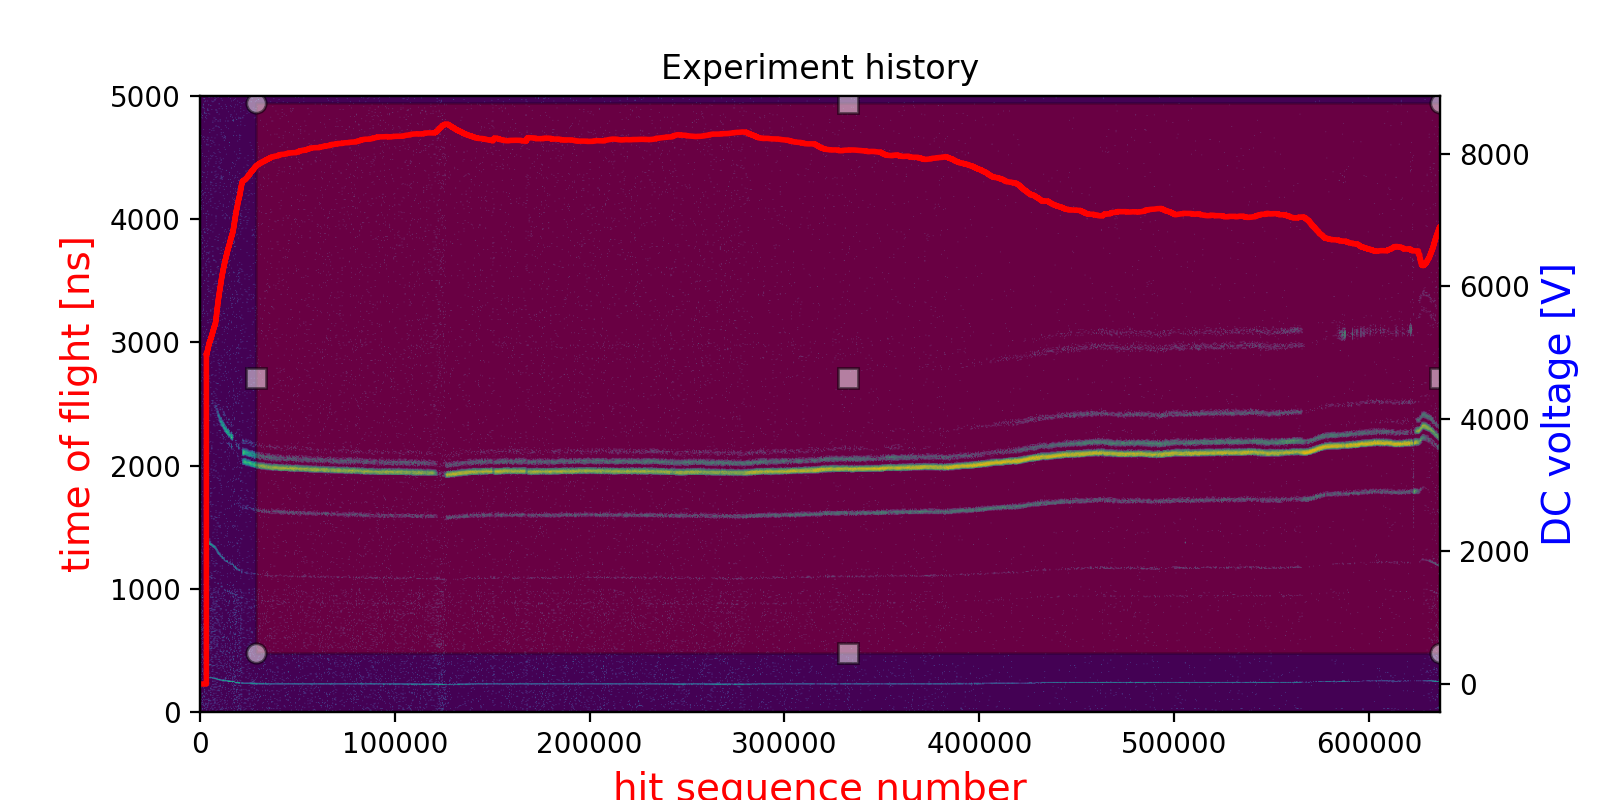

In [20]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
data_loadcrop.plot_graph_for_dld_high_voltage(ax1, dldGroupStorage, save_name = variables.result_path + '//ex_hist_' + dataset_name)



$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [21]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_masterDataframe)

Min Idx: 28703.119997479822 Max Idx: 636416.9006426411


<IPython.core.display.Javascript object>


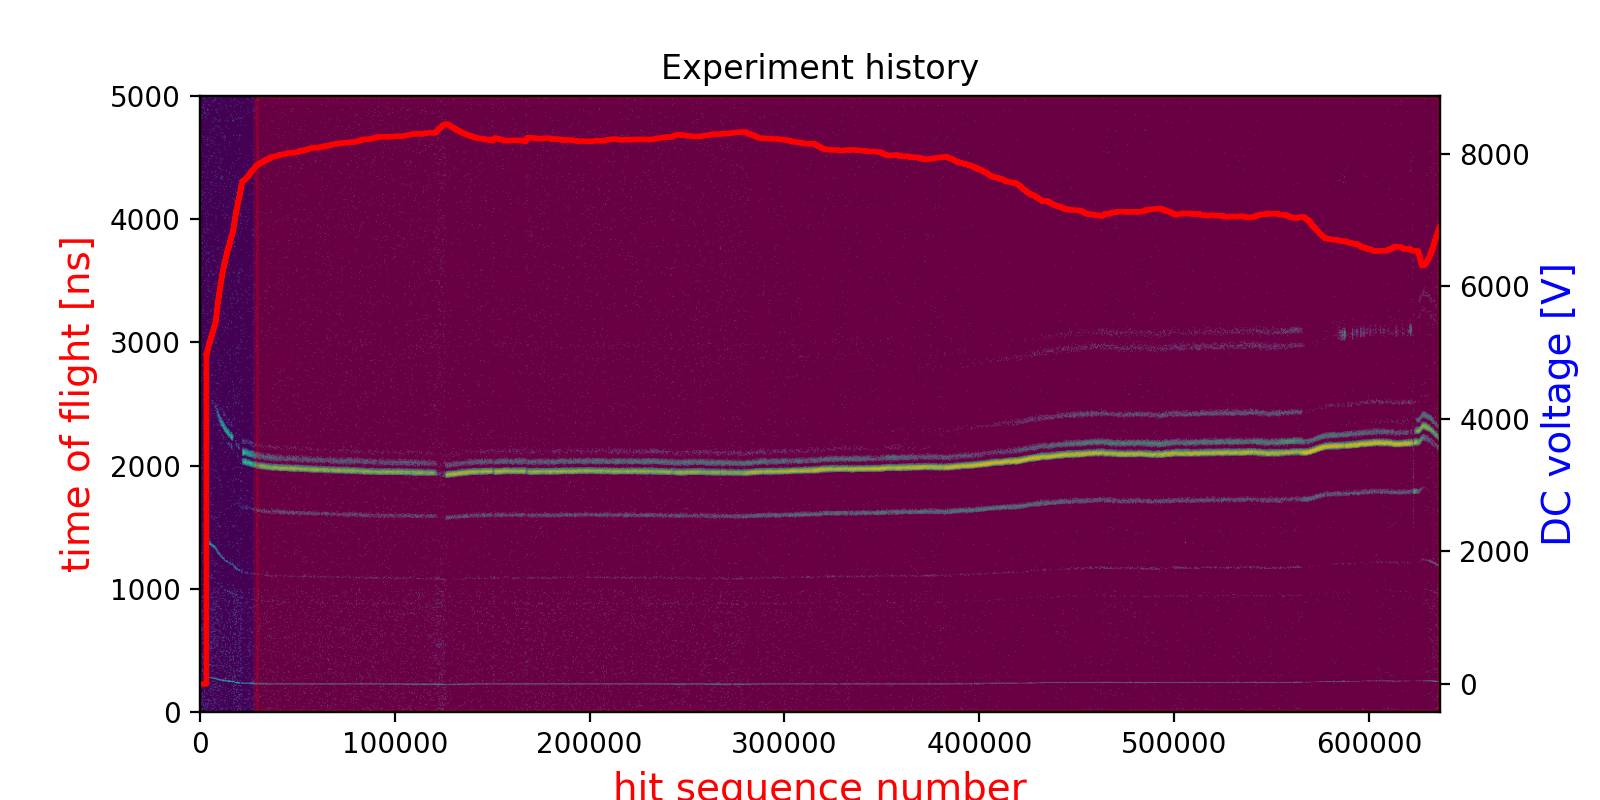

In [22]:
# Plot and selected experiment history
fig1, ax1 = plt.subplots(figsize=(8, 4))
data_loadcrop.plot_graph_for_dld_high_voltage(ax1, dldGroupStorage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

In [ ]:
# Plot and select the FDM
fig1, ax1 = plt.subplots(figsize=(6,6))
data_loadcrop.plot_crop_FDM(ax1, fig1, data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

<IPython.core.display.Javascript object>

$\text {The region selected in the previous step is displayed below.}$

<IPython.core.display.Javascript object>


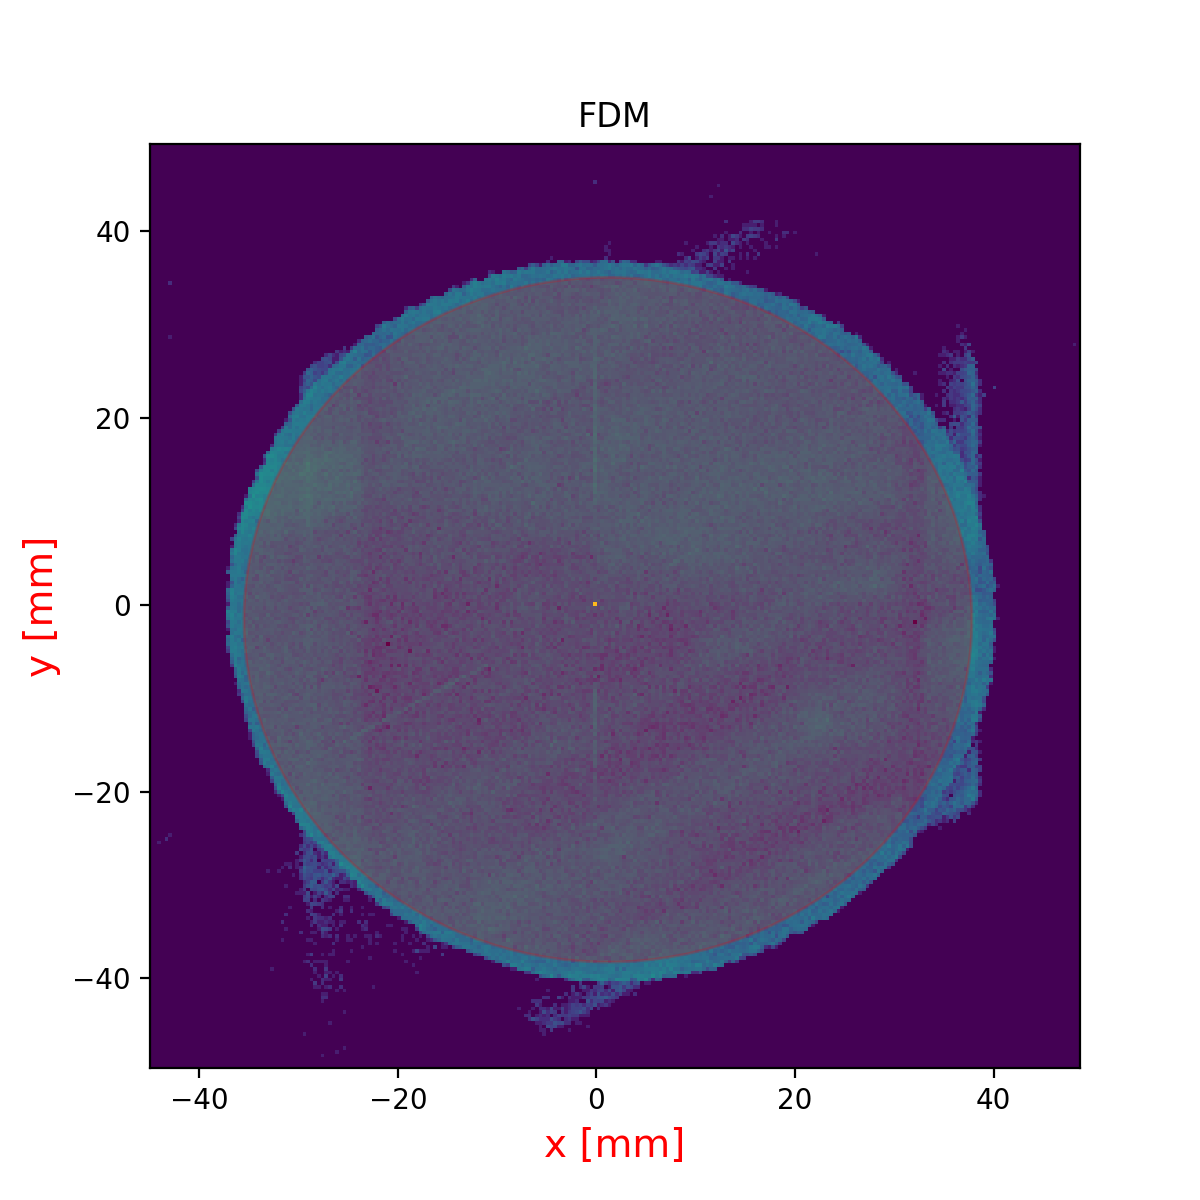

x: 1.1535350776144142 y: -1.5972745303665334 roi: 36.66856109045161


In [10]:
# plot selected area in FDM
fig1, ax1 = plt.subplots(figsize=(6,6))
data_loadcrop.plot_FDM_after_selection(ax1, fig1, data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name)

$\text {The final selected data after processing is shown below.}$

<IPython.core.display.Javascript object>


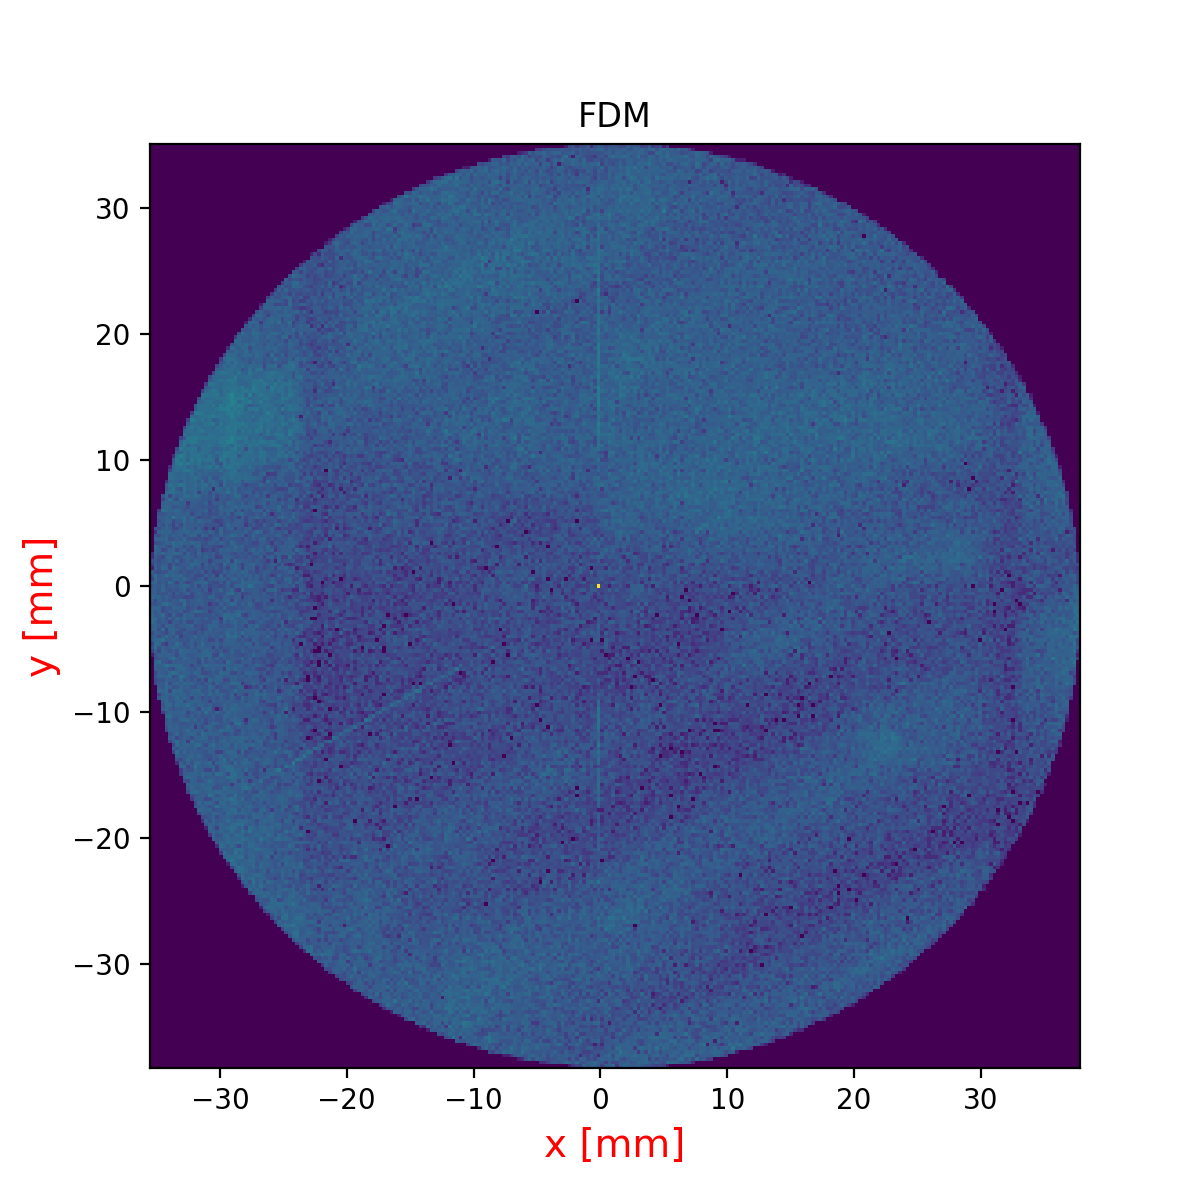

In [11]:
# Crop and plot the dataset
fig1, ax1 = plt.subplots(figsize=(6,6))
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_FDM(ax1, fig1, data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name)

$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [12]:
# save the dataset to hdf5 file
name = os.path.splitext(filename)[0]
data_loadcrop.save_croppped_data_to_hdf5(data_crop_FDM, dld_masterDataframe, savename, tdc_model)

tofCropLossPct 16.157389804197607


In [13]:
# add the dataset to hdf5 file
data_loadcrop.add_croppped_data_to_hdf5(filename, data_crop_FDM, dld_masterDataframe, tdc_model)

tofCropLossPct 16.157389804197607
